# Rocket Supply Chain Optimization

## Background
There are three suppliers we can order rocket engines from. These suppliers have different prices, different yields (% of  engines that pass our stress tests i.e. how many of their shipped engines are functional), and different maximum order amounts. 
We know the:
- prices
- order sizes

We do not know the true yield and can only estimate from past orders. However, as we will use simulated data here based on unobservable parameters SUPPLIER_YIELD and SUPPLIER_YIELD_SD. In reality we would not have access to this information.

The supplier yeild varies widely due to different manufacturing techniques, which also affect the price. We need to estimate the supplier yield from previous batches (taking the differing amounts of data per supplier). Our historical data is biased to some suppliers as we have ordered more from some over others e.g. supplier 3 opened up recently. A Bayesian approach is most appropriate here since it handles small to medium datasets very well compared to a frequentist approach. 

## Aim: Estimate Supplier Yield (Distribution) to inform the number of engines to order from each supplier to meet demand

Source: https://twiecki.io/blog/2019/01/14/supply_chain/ 

In [2]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
SUPPLIER_YIELD = np.array([.9, .5, .8]) # unknown
SUPPLIER_YIELD_SD = np.array([.1, .2, .2]) # unknown
PRICES = [220.0, 100.0, 120.0] # known
MAX_ORDER_SIZE = [100, 80, 100] # known
N_OBS = [30, 20, 2] # history of number of orders from suppliers 1,2,3

In [4]:
# generate syntheic data with Beta distribution using specified mean & sd yield
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ])]

In [5]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
data_tidy

yield
supplier obs          
0        0    0.978235
         1    0.989461
         2    0.990351
         3    0.837627
         4    0.661303
...                ...
2        25        NaN
         26        NaN
         27        NaN
         28        NaN
         29        NaN

[90 rows x 1 columns]

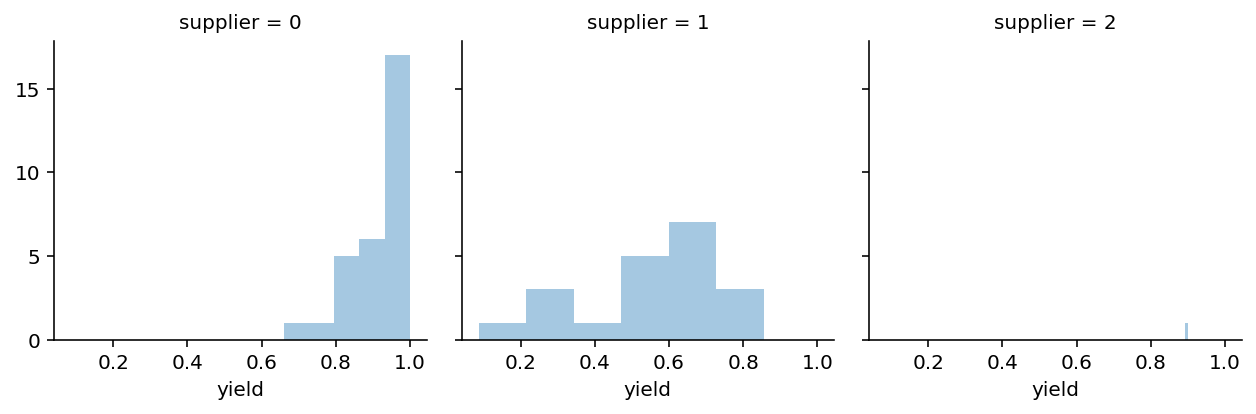

In [6]:
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

## Parameterize the dynamics of operating the spaceport
Assume that a rocket can sell for 500 bitcoins (BTC) and costs 100 BTC to hold. 

### Define Loss Function (Supply-Demand function)
Takes into account:
- how many engines we have in stock, 
- how many launches customers want, 
- at what price we bought the engine, 
- at what price we can sell the launch, and 
- what the holding costs are per engine

In [7]:
SALES_PRICE = 500 
HOLDING_COST = 100

@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per launch
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # Usually we minimize, so invert
    return -reward

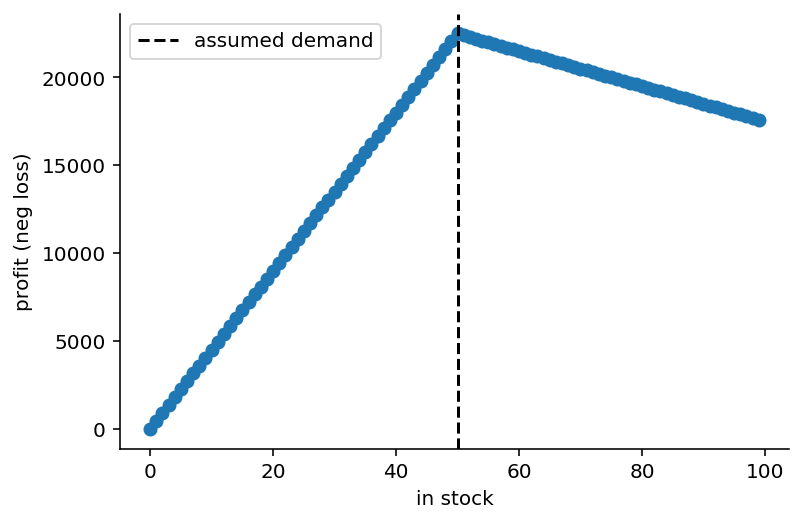

In [8]:
in_stock = np.arange(0, 100)
plt.scatter(in_stock, -loss(in_stock, 50, 50)); plt.axvline(50, c='k', ls='--', label='assumed demand');
plt.xlabel('in stock'); plt.ylabel('profit (neg loss)'); sns.despine(); plt.legend();

If we assume that the customer demand is 50 launches, we maximize the profit if match that demand exactly with 50 rocket engines.
If we have fewer than 50 engines in stock, we make less profit. Notice that if we have excess engines (more than demand), the decrease
in profit is less steep than if we can''t meet demand. This is because the cost of holding the extra engines does not exceed the profit 
margins of selling them. Buy price was assumed to be 50 BTC.

Next, we generate history of launches (or demand) by assuming a poisson distribution.

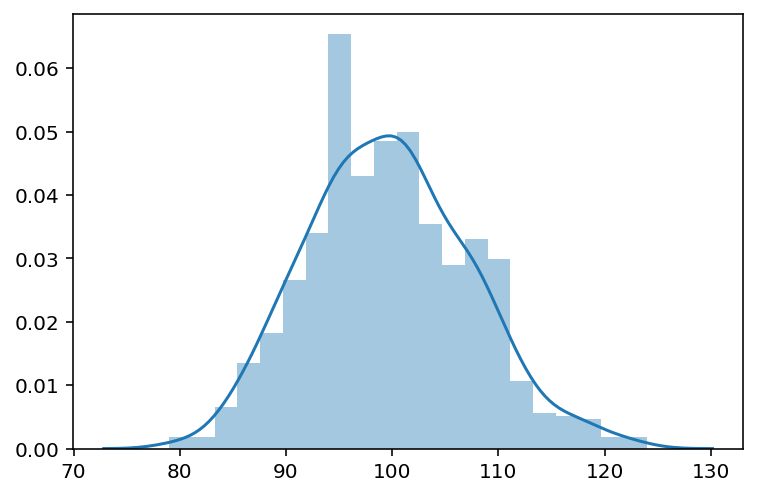

In [10]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples)

In [16]:
demand_samples

array([ 96,  84,  91,  99,  94, 105, 101, 102, 109, 110, 105,  92,  94,
       108,  97,  90,  94, 108,  93,  90, 106,  96, 103, 114, 100, 107,
        93,  98,  95,  98,  92, 108, 104,  99, 109,  96,  84, 104,  94,
        89,  99, 109,  86, 101, 113,  99, 102,  95,  98, 103,  83,  89,
       108, 107,  90, 113, 105, 101, 112, 102, 101,  92,  91, 115,  89,
        97,  94,  88,  89, 100,  99, 102, 100, 102,  99,  92, 101, 107,
        99, 108, 107, 111, 101, 101, 104,  97, 102,  96,  92, 103,  97,
       104, 100,  89, 105,  90,  91,  99, 100,  91,  93,  97,  98,  89,
       111,  86,  89,  90, 106, 109, 100, 104, 100, 101, 101,  90,  92,
       101, 100, 109, 109,  94,  96, 116, 101,  91,  88, 102, 104, 100,
        94,  89,  98, 109,  97,  96, 113, 104,  93, 103, 104,  99,  97,
       112,  95, 100,  95,  95,  95,  96,  96, 108, 100,  98, 119, 105,
        99,  98,  99,  93, 105,  97,  93,  94,  97,  94,  92, 116, 110,
        96, 105, 102, 103, 110, 101, 103,  99,  98, 100,  94, 11

Let's plot the profit for each demand sample using the loss function. We assume that we have 100 rocket engines in stock and buy price is 10 BTC this time.

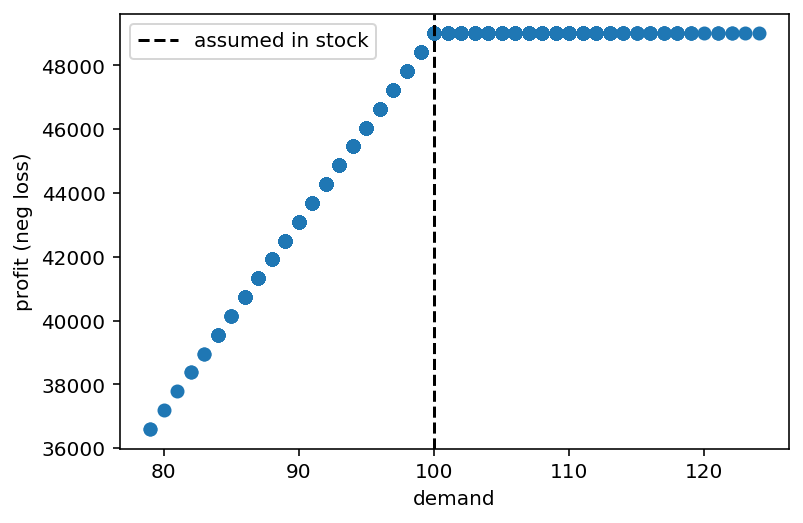

In [11]:
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=10))
plt.xlabel('demand'); plt.ylabel('profit (neg loss)'); plt.axvline(100, c='k', ls='--', label='assumed in stock');
plt.legend();

In response to demand, the loss-function behaves differently: with less demand than what we have in stock, we earn less (because we sell fewer launches but also have to pay holding costs), but as demand exceeds the number of engines we have in stock our profit stays flat because we can't sell more than what we have.

We alse tried with buy_price=50, whcih just decreases the profit margins. 

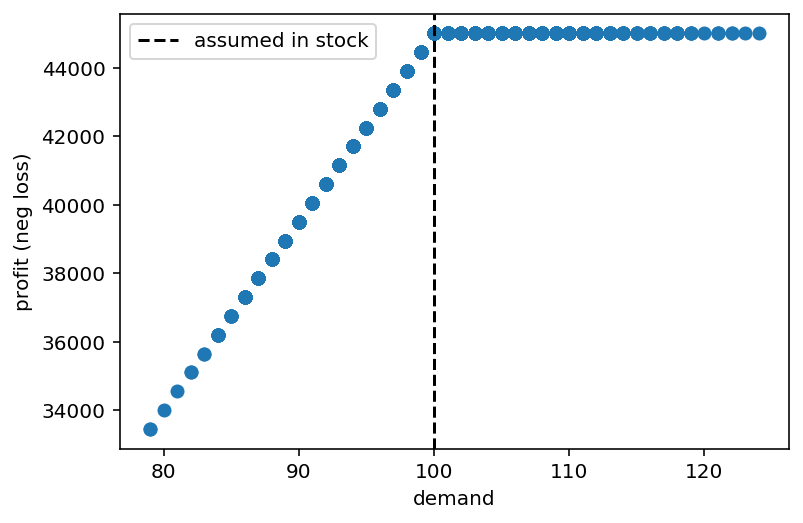

In [15]:
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=50))
plt.xlabel('demand'); plt.ylabel('profit (neg loss)'); plt.axvline(100, c='k', ls='--', label='assumed in stock');
plt.legend();

## Estimate the true yield of every supplier using a Bayesian model

In [17]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sd=10., shape=3) + 1
    β = pm.HalfNormal('β', sd=10., shape=3) + 1
    
    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
            alpha=α[i], beta=β[i],
            observed=d)
    
    trace = pm.sample()

C:\Users\Lorre\anaconda3\lib\site-packages\pymc3\sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 101 seconds.


C:\Users\Lorre\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


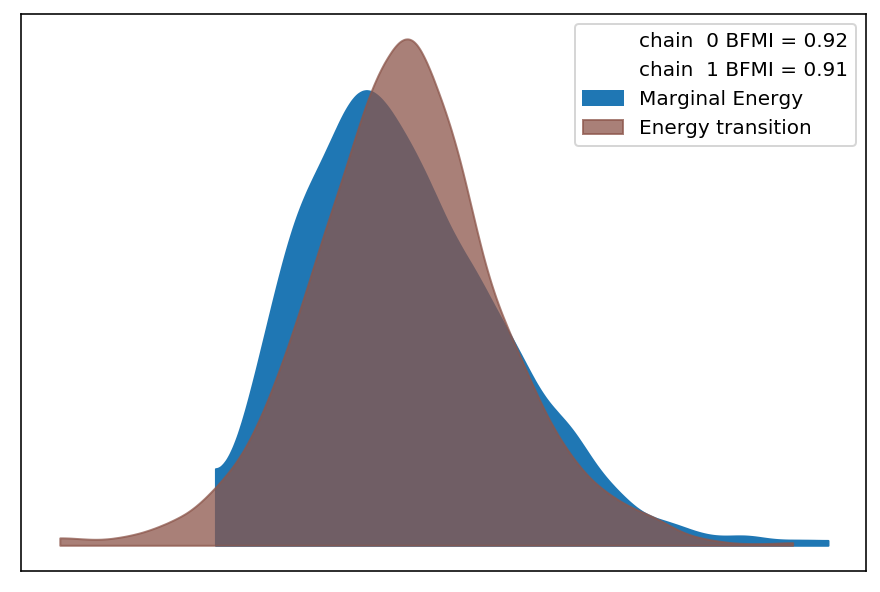

In [18]:
# make sure convergence looks good
az.plot_energy(trace)

## Generate New Data based on our Estimated Posteriors

In [19]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, 1000)

C:\Users\Lorre\anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [20]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
data_tidy

yield
supplier             obs          
supplier_yield_obs_0 0    0.810846
                     1    0.746664
                     2    0.832556
                     3    0.925262
                     4    0.989602
...                            ...
supplier_yield_obs_2 995  0.964840
                     996  0.990941
                     997  0.947417
                     998  0.805498
                     999  0.828862

[3000 rows x 1 columns]

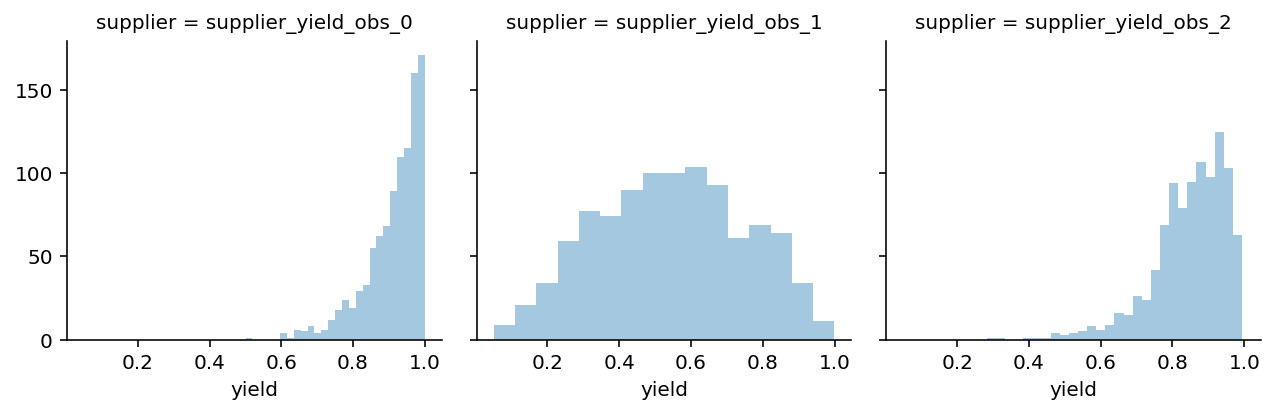

In [21]:
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

This plot shows, given the data and our model, what we can expect to observe. Note that these predictions take the uncertainty into account. For supplier 2 we have a lot of uncertainty because we only observed very few data points.

Given these estimates we can write a function that converts the orders we place to each supplier, the yield we assume for each one, and what their prices are.

In [22]:
def calc_yield_and_price(orders, 
                         supplier_yield=np.array([.9, .5, .8]),
                         prices=PRICES
                        ):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price([100, 60, 60])

(168.0, 160.0)

So given these (randomly picked) order amounts to each supplier and some deterministic yield, we would receive 168 functioning engines at an effective price of 160 BTC each.

## Bayesian Decion Making (optimization based on estimated yields)
First, we need to specify our objective function which will compute the total yield and effective price given a posterior predictive sample. Once we have that and our demand (also a sample from that distribution), we can compute our loss. As we have a distribution over possible scenarios, we compute the loss for each one and return the distribution.

In [23]:
def objective(orders, supplier_yield=supplier_yield_post_pred,
              demand_samples=demand_samples, max_order_size=MAX_ORDER_SIZE):
    orders = np.asarray(orders)
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(orders < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(orders > MAX_ORDER_SIZE):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, supplier_yield_sample in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=supplier_yield_sample
        )
        
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i = loss(full_yield, demand_samples[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

In [24]:
from scipy import optimize

# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]
starting_value = [50., 50., 50.]

# minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: np.mean(objective(*args)), 
                              starting_value, 
                              bounds=bounds)

print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_stoch.x)))
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_stoch.x))))

C:\Users\Lorre\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Optimal order amount from every supplier = [  0.  80. 100.]
Total order amount from all suppliers = 180.0


Great, we did it! Excitedly you go to your manager and tell her the amazing model you built and the optimal order amounts. Unfortunately, she is not impressed and asks "that's some fancy technique, but I'm not convinced this is actually better than what we currently use which is to just take the means of the yield distribution for each supplier."

## Compare to Single Sample (the mean) from the Bayesian model
Instead of samples from the posterior predictive, we can just pass a single sample -- the mean -- into our objective function.

In [25]:
supplier_yield_mean = pd.DataFrame([np.mean(d) for d in data]).T # compute mean from synthetic yields
supplier_yield_mean

,0,1,2
0,0.918735,0.558903,0.896244


In [26]:
opt_non_stoch = optimize.minimize(lambda *args: objective(*args, 
                                                          supplier_yield=supplier_yield_mean, 
                                                          demand_samples=[100]), 
                                  starting_value, 
                                  bounds=bounds)
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_non_stoch.x)))
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_non_stoch.x))))

Optimal order amount from every supplier = [42. 46. 42.]
Total order amount from all suppliers = 128.0


Results are different this time around

In [27]:
np.random.seed(123)
data_new = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data_new.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=1000).random())
data_new = pd.DataFrame(data_new).T
data_new.head().add_prefix("Supplier ")

,Supplier 0,Supplier 1,Supplier 2
0,0.880298,0.752686,0.997934
1,0.698046,0.307304,0.971085
2,0.676807,0.534287,0.891209
3,0.943773,0.666368,0.975907
4,0.911538,0.457898,0.556483


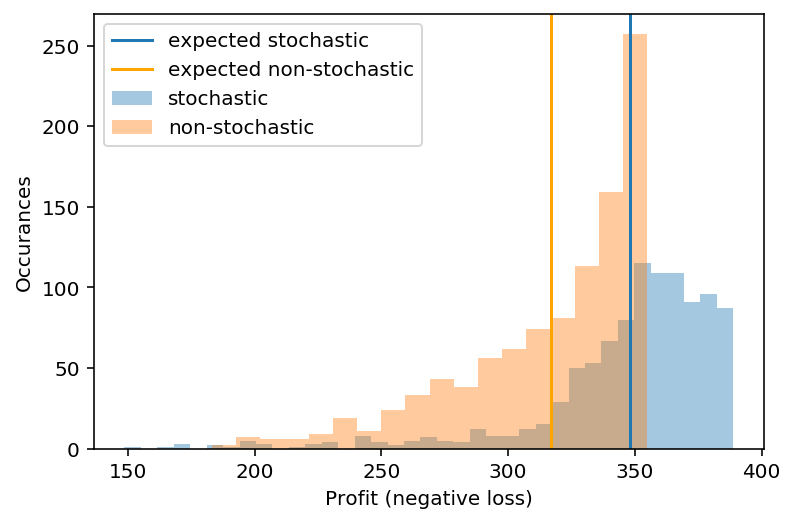

In [28]:
neg_loss_stoch = -objective(opt_stoch.x, supplier_yield=data_new) / demand_samples
neg_loss_non_stoch = -objective(opt_non_stoch.x, supplier_yield=data_new) / demand_samples
sns.distplot(neg_loss_stoch, label='stochastic', kde=False)
plt.axvline(np.mean(neg_loss_stoch), label='expected stochastic')
sns.distplot(neg_loss_non_stoch, label='non-stochastic', kde=False)
plt.axvline(np.mean(neg_loss_non_stoch), color='orange', label='expected non-stochastic')
plt.legend(); plt.xlabel('Profit (negative loss)'); plt.ylabel('Occurances');

In [29]:
neg_loss_stoch

array([322.21365317, 344.01652652, 343.98354615, 336.46448287,
       381.77364917, 367.37891   , 350.88542878, 354.54388325,
       225.40568024, 385.19589277, 378.4786809 , 382.71095579,
       324.61875118, 375.24150864, 341.99322212, 324.32783102,
       362.98704965, 375.91043672, 346.24691223, 382.27103937,
       265.16029935, 342.41963258, 372.05285719, 373.88180788,
       342.26488387, 329.62245193, 344.40112922, 355.37610679,
       243.66859086, 298.28007665, 342.36830076, 380.75908232,
       377.23577241, 373.54583011, 370.82610595, 356.30050782,
       330.76224248, 386.14462246, 372.2808477 , 345.95511979,
       367.92589378, 362.53871561, 361.15108953, 329.61196755,
       168.65891375, 350.919473  , 344.24138539, 335.13294488,
       385.36618426, 376.64077187, 326.56708644, 340.76107981,
       243.50615794, 351.83164822, 351.66080075, 383.14220221,
       376.25414831, 332.57249822, 335.64986342, 344.81705983,
       386.46083285, 371.10639477, 373.12643794, 365.26

In [30]:
print('Expected profit of Bayesian model = %.2f BTC' % np.mean(neg_loss_stoch))
print('Expected profit of naive model = %.2f BTC' % np.mean(neg_loss_non_stoch))
print('Expected value of including uncertainty = %.2f BTC' % (np.mean(neg_loss_stoch) - np.mean(neg_loss_non_stoch)))

Expected profit of Bayesian model = 347.95 BTC
Expected profit of naive model = 317.01 BTC
Expected value of including uncertainty = 30.94 BTC


## Potential Next Steps

- What to do if convergence doesnt look good?
- Use prophet to forecast demand
- Use a hierarchical model for yield estimation
- Deployment Considerations
- what if the holding cost of the engine changes over time e.g. 50 BTC for the first day then 20 BTC/ per day after that?
- what if we assumed diff priors on alpha and beta parameters for each supplier?